In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from scipy import stats
from itertools import product
from datetime import datetime
import seaborn as sns
import warnings

In [0]:
!pip install pmdarima

In [0]:
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

In [0]:
df = pd.read_csv("/content/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv", names = ['Timestamp', 'Open', 'High', 'Low', 'Close', "VBTC", 'VWEIGHT', 'Weighted_Price'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
df = df.resample('D').mean()
df['Weighted_Price_box'], lmbda = stats.boxcox(df.Weighted_Price)
df['Weighted_Price_box']

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


Timestamp
1970-01-01             NaN
1970-01-02             NaN
1970-01-03             NaN
1970-01-04             NaN
1970-01-05             NaN
                  ...     
2019-01-03    2.686944e+29
2019-01-04    2.433298e+29
2019-01-05    2.714795e+29
2019-01-06    2.962809e+29
2019-01-07    4.093449e+29
Freq: D, Name: Weighted_Price_box, Length: 17904, dtype: float64

In [0]:
result = adfuller(df.Weighted_Price.dropna())
print('ADF Statistics : %f '% result[0])
print("p-value : %f"% result[1])

ADF Statistics : -1.794445 
p-value : 0.383223


Since the value of p is greater than the significance level so we will perform differencing and determine the order of differencing.

In [0]:
# 1st Differencing
result = adfuller(df.Weighted_Price.diff().dropna())
print('ADF Statistics : %f '% result[0])
print("p-value : %f"% result[1])

# 2nd Differencing
#result = adfuller(df.Weighted_Price_box.diff().diff().dropna())
#print('ADF Statistics : %f '% result[0])
#print("p-value : %f"% result[1])


ADF Statistics : -6.704274 
p-value : 0.000000


In [0]:
def difference(df, interval = 1):
  diff = list()
  for i in range(interval, len(df)):
    value = df[i] - df[i - interval]
    diff.append(value)
  return np.array(diff)

def inverse_difference(history, yhat, value = 1):
  return yhat + history[-value]

As the value of p is less than the significance level, we shall fix the value of d.

In [0]:
y = df.Weighted_Price.fillna(df.Weighted_Price.mean())
#ADF Test
print(ndiffs(y, test = 'adf'))

#KPSS Test
print(ndiffs(y, test = 'kpss'))

#PP Test
print(ndiffs(y, test = 'pp'))


0
1
0


In [0]:
diff = difference(y, 365)

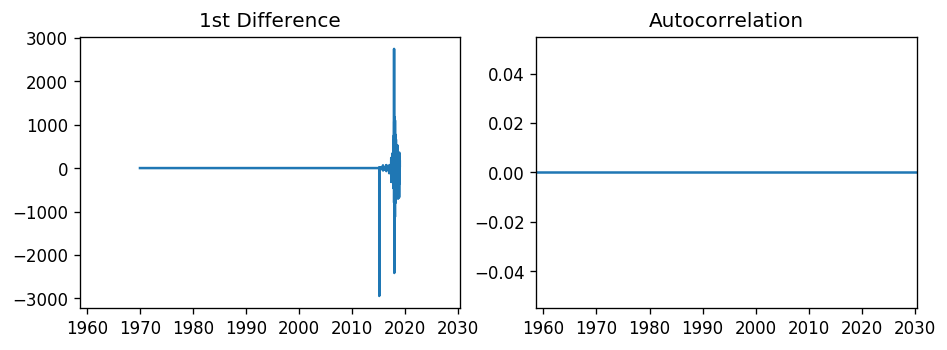

In [0]:
#PACF plot of the 1st difference series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

#fig,axes = plt.subplots(1,2, sharex = True)
#axes[0].plot(df.Weighted_Price_box); axes[0].set_title("Original Series")
#xes[1].set(ylim = (0,5))
#plot_pacf(df.Weighted_Price_box.dropna(), ax = axes[1])

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y.diff()); axes[0].set_title('1st Difference')
#axes[1].set(ylim = (0,5))
plot_acf(y.diff(), ax=axes[1])


plt.show()

In [0]:
model = ARIMA(diff, order = (1, 1, 2))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                17538
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -103162.575
Method:                       css-mle   S.D. of innovations             86.772
Date:                Wed, 11 Mar 2020   AIC                         206335.150
Time:                        09:26:31   BIC                         206374.011
Sample:                             1   HQIC                        206347.946
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7097      0.805     -0.882      0.378      -2.288       0.868
ar.L1.D.y     -0.9449      0.007   -140.363      0.000      -0.958      -0.932
ma.L1.D.y      1.1473      0.009    120.788      0.0

In [0]:
model = ARIMA(y, order = (2, 1, 2))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Weighted_Price   No. Observations:                17903
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -100799.444
Method:                       css-mle   S.D. of innovations             67.449
Date:                Wed, 11 Mar 2020   AIC                         201610.888
Time:                        08:59:40   BIC                         201657.645
Sample:                    01-02-1970   HQIC                        201626.268
                         - 01-07-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0490      0.615      0.080      0.937      -1.157       1.255
ar.L1.D.Weighted_Price    -0.8662      0.037    -23.337      0.000      -0.939      -0.793
ar.L

As there is no considerable change in MA1 and MA2, we shall take the values of p and q as 1 and 2 respectively.


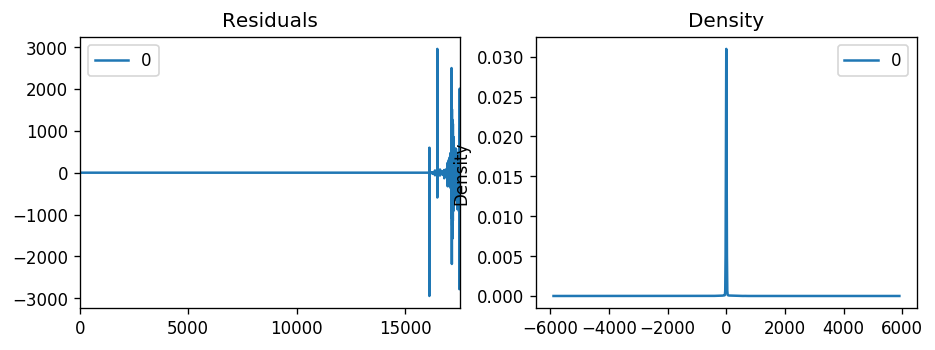

In [0]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(kind = "kde", title = "Density", ax = ax[1])
plt.show()

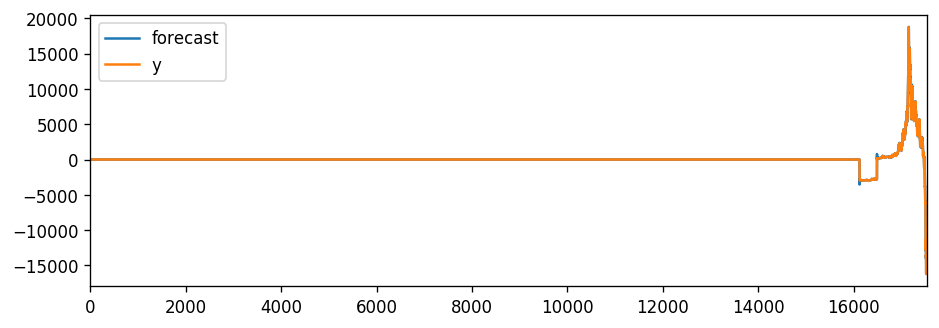

In [0]:
model_fit.plot_predict(dynamic = False)
plt.show()

In [0]:
#Prediction
forecast = model_fit.forecast(steps = 30)[0]
history = [x for x in df.Weighted_Price]
day = 1
for yhat in forecast:
  inverted = inverse_difference(history, yhat, 365)
  print("Day %d : %f" % (day, inverted))
  history.append(inverted)
  day += 1

Day 1 : 19382.880248
Day 2 : 18954.528379
Day 3 : 18278.927324
Day 4 : 17773.692668
Day 5 : 17716.088611
Day 6 : 18273.532648
Day 7 : 17752.611546
Day 8 : 17846.042544
Day 9 : 16250.959670
Day 10 : 14749.673555
Day 11 : 15540.262904
Day 12 : 15555.049022
Day 13 : 16481.706500
Day 14 : 15936.507402
Day 15 : 15151.492375
Day 16 : 14755.076973
Day 17 : 15030.776206
Day 18 : 15319.463586
Day 19 : 15051.517681
Day 20 : 15237.621394
Day 21 : 15485.536960
Day 22 : 15197.647673
Day 23 : 14680.158266
Day 24 : 14038.987598
Day 25 : 13473.985282
Day 26 : 12608.013204
Day 27 : 12969.374913
Day 28 : 12797.242618
Day 29 : 11674.258857
Day 30 : 10867.190293


In [0]:
start_index = len(diff)
end_index = start_index + 30
forecast1 = model_fit.predict(start = start_index, end = end_index)
history = [x for x in df.Weighted_Price]
day = 1
for yhat in forecast:
  inverted = df.Weighted_Price[-1] + inverse_difference(history, yhat, 365)
  print("Day %d : %f" % (day, inverted))
  history.append(inverted)
  day += 1

Day 1 : 23407.897864
Day 2 : 22979.545996
Day 3 : 22303.944940
Day 4 : 21798.710284
Day 5 : 21741.106228
Day 6 : 22298.550265
Day 7 : 21777.629163
Day 8 : 21871.060161
Day 9 : 20275.977286
Day 10 : 18774.691171
Day 11 : 19565.280520
Day 12 : 19580.066638
Day 13 : 20506.724117
Day 14 : 19961.525018
Day 15 : 19176.509991
Day 16 : 18780.094590
Day 17 : 19055.793822
Day 18 : 19344.481202
Day 19 : 19076.535298
Day 20 : 19262.639011
Day 21 : 19510.554576
Day 22 : 19222.665290
Day 23 : 18705.175882
Day 24 : 18064.005214
Day 25 : 17499.002898
Day 26 : 16633.030820
Day 27 : 16994.392529
Day 28 : 16822.260235
Day 29 : 15699.276473
Day 30 : 14892.207909
